In [107]:
import numpy as np
from easydict import EasyDict
from collections import defaultdict
from sksurv.metrics import concordance_index_ipcw

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.models import DeepHitSingle

from survtrace.dataset import load_data

In [108]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [109]:

# define the setup parameters
pc_hazard_config = EasyDict({
    'data': 'metabric',
    'horizons': [.25, .5, .75],
    'batch_size': 64,
    'learning_rate': 0.01,
    'epochs': 50,
    'hidden_size': 32
})
pc_hazard_config = EasyDict({
    'data': 'support',
    'horizons': [.25, .5, .75],
    'batch_size': 128,
    'learning_rate': 0.01,
    'epochs': 50,
    'hidden_size': 32
})

# load data
df, df_train, df_y_train, df_test, df_y_test, df_val, df_y_val = load_data(pc_hazard_config)


x_train = np.array(df_train, dtype='float32')
x_val = np.array(df_val, dtype='float32')
x_test = np.array(df_test, dtype='float32')

y_df_to_tuple = lambda df: tuple([np.array(df['duration'], dtype='int64'), np.array(df['event'], dtype='float32')])

y_train = y_df_to_tuple(df_y_train)
y_val = y_df_to_tuple(df_y_val)

In [110]:
x_train

array([[ 1.        ,  4.        , 13.        , ...,  0.7305259 ,
         0.71663004, -0.3993534 ],
       [ 1.        ,  6.        , 15.        , ..., -0.4226419 ,
        -0.39424053, -0.57641363],
       [ 0.        ,  3.        , 13.        , ...,  1.389479  ,
        -1.3216099 , -0.81252986],
       ...,
       [ 0.        ,  6.        , 13.        , ..., -0.4226419 ,
         0.06957006, -0.16312902],
       [ 0.        ,  3.        , 13.        , ..., -0.9168567 ,
        -0.49123633, -0.16312902],
       [ 1.        ,  5.        , 14.        , ..., -0.4226419 ,
         0.86744225, -0.28131327]], dtype=float32)

In [111]:
y_train

(array([1, 3, 0, ..., 1, 0, 3]),
 array([1., 0., 1., ..., 1., 1., 0.], dtype=float32))

In [112]:
hidden_size = pc_hazard_config.hidden_size
batch_norm = True
dropout = 0.1

net = torch.nn.Sequential(
    torch.nn.Linear(pc_hazard_config.num_feature, hidden_size),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(hidden_size),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(hidden_size),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(hidden_size, pc_hazard_config.out_feature)
)

In [113]:
pc_hazard_config.out_feature

4

In [114]:
model = DeepHitSingle(net, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=np.array(pc_hazard_config['duration_index'], dtype='float32'))
model.optimizer.set_lr(pc_hazard_config.learning_rate)
callbacks = [tt.callbacks.EarlyStopping(patience=20)]


In [115]:
log = model.fit(x_train, y_train, pc_hazard_config.batch_size, pc_hazard_config.epochs, callbacks, val_data=tuple([x_val, y_val]))


0:	[0s / 0s],		train_loss: 0.7066,	val_loss: 0.6089
1:	[0s / 0s],		train_loss: 0.6184,	val_loss: 0.6142
2:	[0s / 1s],		train_loss: 0.6088,	val_loss: 0.5996
3:	[0s / 1s],		train_loss: 0.6023,	val_loss: 0.6126
4:	[0s / 1s],		train_loss: 0.5989,	val_loss: 0.6138
5:	[0s / 2s],		train_loss: 0.5969,	val_loss: 0.5949
6:	[0s / 2s],		train_loss: 0.5926,	val_loss: 0.5982
7:	[0s / 2s],		train_loss: 0.5935,	val_loss: 0.5960
8:	[0s / 3s],		train_loss: 0.5926,	val_loss: 0.5922
9:	[0s / 3s],		train_loss: 0.5913,	val_loss: 0.5906
10:	[0s / 3s],		train_loss: 0.5923,	val_loss: 0.5932
11:	[0s / 3s],		train_loss: 0.5904,	val_loss: 0.5975
12:	[0s / 4s],		train_loss: 0.5885,	val_loss: 0.5971
13:	[0s / 4s],		train_loss: 0.5902,	val_loss: 0.5926
14:	[0s / 4s],		train_loss: 0.5867,	val_loss: 0.6043
15:	[0s / 5s],		train_loss: 0.5874,	val_loss: 0.5891
16:	[0s / 5s],		train_loss: 0.5860,	val_loss: 0.5907
17:	[0s / 5s],		train_loss: 0.5859,	val_loss: 0.5932
18:	[0s / 5s],		train_loss: 0.5862,	val_loss: 0.5947
19:

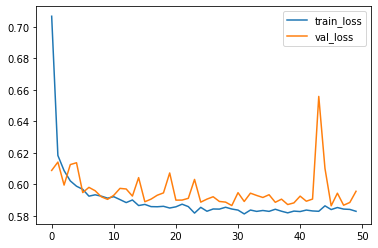

In [116]:
_ = log.plot()

In [117]:
class Evaluator:
    def __init__(self, df, train_index):
        '''the input duration_train should be the raw durations (continuous),
        NOT the discrete index of duration.
        '''
        self.df_train_all = df.loc[train_index]

    def eval_single(self, model, test_set, config, val_batch_size=None):
        df_train_all = self.df_train_all
        get_target = lambda df: (df['duration'].values, df['event'].values)
        durations_train, events_train = get_target(df_train_all)
        print('durations_train', durations_train)
        et_train = np.array([(events_train[i], durations_train[i]) for i in range(len(events_train))],
                        dtype = [('e', bool), ('t', float)])
        print('et_train', et_train)
        times = config['duration_index'][1:-1]
        print('times', times)
        horizons = config['horizons']

        df_test, df_y_test = test_set
        surv = model.predict_surv(df_test, batch_size=val_batch_size)
        risk = np.array((1 - surv))
        print('risk', risk)
        
        durations_test, events_test = get_target(df_y_test)
        print('durations_test', durations_test)
        print('events_test', events_test)
        et_test = np.array([(events_test[i], durations_test[i]) for i in range(len(events_test))],
                    dtype = [('e', bool), ('t', float)])
        print('et_test', et_test)
        metric_dict = defaultdict(list)
        cis = []
        for i, _ in enumerate(times):
            print('iteration', i)
            print('risk', risk[:, i])
            print(times)
            cis.append(
                concordance_index_ipcw(et_train, et_test, estimate=risk[:, i], tau=times[i])[0]
                )
            metric_dict[f'{horizons[i]}_ipcw'] = cis[i]


        for horizon in enumerate(horizons):
            print(f"For {horizon[1]} quantile,")
            print("TD Concordance Index - IPCW:", cis[horizon[0]])
        
        return metric_dict

In [118]:
evaluator = Evaluator(df, df_train.index)
evaluator.eval_single(model, (x_test, df_y_test), config=pc_hazard_config)

durations_train [ 30. 892.   7. ...  36.   6. 879.]
et_train [( True,  30.) (False, 892.) ( True,   7.) ... ( True,  36.) ( True,   6.)
 (False, 879.)]
times [ 14.    57.   250.25]
risk [[0.2177633  0.38699532 0.53883547 0.6833942 ]
 [0.2147736  0.3488465  0.5132638  0.6641889 ]
 [0.19607466 0.35568905 0.5194777  0.6842519 ]
 ...
 [0.19536984 0.35115522 0.5187078  0.7301536 ]
 [0.15776908 0.37403667 0.59437346 0.7732872 ]
 [0.15216696 0.33073056 0.5043775  0.72474706]]
durations_test [  31.  827.   79. ...  640.   51. 1388.]
events_test [1 0 1 ... 0 1 1]
et_test [( True,   31.) (False,  827.) ( True,   79.) ... (False,  640.)
 ( True,   51.) ( True, 1388.)]
iteration 0
risk [0.2177633  0.2147736  0.19607466 ... 0.19536984 0.15776908 0.15216696]
[ 14.    57.   250.25]
iteration 1
risk [0.38699532 0.3488465  0.35568905 ... 0.35115522 0.37403667 0.33073056]
[ 14.    57.   250.25]
iteration 2
risk [0.53883547 0.5132638  0.5194777  ... 0.5187078  0.59437346 0.5043775 ]
[ 14.    57.   250.25

defaultdict(list,
            {'0.25_ipcw': 0.6366912258602219,
             '0.5_ipcw': 0.5983739780088758,
             '0.75_ipcw': 0.5846928426839386})